In [35]:
import h5py
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

file = h5py.File('E:/dataset_6ms.h5', 'r')

gender_labels = file['gender'][...].squeeze().astype(str)
print('loading data from disk...')


indexes =  np.where(gender_labels == 'female')
# ignore labels == 1 == 'calm' because of low frequency 
labels = file['label'][indexes].squeeze()

print(np.unique(labels, return_counts=True))
indexs = np.where(labels != 1)
_labels = labels[indexs]
print(np.unique(_labels, return_counts=True))

enc = LabelEncoder()

y = enc.fit_transform(_labels)
print(np.unique(y, return_counts=True))
X = file['mfcc'][indexs ]
print('data loaded! calculating mfcc delta features for data...')


print(f" {X.shape}, {y.shape}")

# extract delta and double delta features using librosa
X_deltas = np.zeros((X.shape[0], X.shape[1]*3, X.shape[2]))
print(X_deltas.shape)
for i in range(X.shape[0]):
    X_delta = librosa.feature.delta(X[i])
    X_delta2 = librosa.feature.delta(X[i], order=2)
    
    # np.vstack all the X, X_delta and X_delta2 
    # new_features = np.vstack([X[i], X_delta, X_delta2])
    # interweave the X, X_delta and X_delta2
    # new_features = np.stack((stacks.T), axis=2).reshape(6,10)
    # print(X_delta2.shape, X_delta.shape, X[i].shape)
    new_features = np.stack((X_delta2.T, X_delta.T, X[i].T), axis=2).reshape(X.shape[1]*3,X.shape[2])
    X_deltas[i] = new_features

print("done.")
print("creating test train split...")
X_train, X_test, y_train, y_test = train_test_split(X_deltas, y, test_size=0.33, random_state=32)
print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

loading data from disk...
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([4239,  470, 4723, 5299, 4768, 4634], dtype=int64))
(array([0, 2, 3, 4, 5], dtype=int64), array([4239, 4723, 5299, 4768, 4634], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([4239, 4723, 5299, 4768, 4634], dtype=int64))
data loaded! calculating mfcc delta features for data...
 (23663, 13, 50), (23663,)
(23663, 39, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(13, 50) (13, 50) (13, 50)
(

In [36]:

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Add
from keras.layers import Flatten, Dropout, LeakyReLU, Permute, Activation, Concatenate
from keras.layers import Conv2D, MaxPooling2D, Reshape, AveragePooling2D
from keras.layers import Conv1D, Layer, Input, BatchNormalization, BatchNormalizationV2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import adam_v2
import tensorflow as tf
import datetime
# import rms prop from keras

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'mfcc_resnet-'+timestr  # or 'cifar-10_plain_net_30-'+timestr
checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"

num_of_labels = np.unique(y).shape[0]
# print(num_of_labels)
num_of_mfccs = 13

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
cp = cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0
)
opt = adam_v2.Adam()


def res_block(x_in, channels_in, kernel: tuple, downsample=False):
    x = x_in
    x = Conv2D(channels_in, kernel, padding='same',
               strides=((1, 2)[int(downsample)]))(x_in)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(channels_in, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    if downsample:
        # match x_in to shape of x
        x_in = Conv2D(kernel_size=1, strides=2,
                      filters=channels_in, padding='same')(x_in)
    res = Add()([x, x_in])
    res = LeakyReLU()(res)

    return res


feature_shape = X_train[0].shape
print(feature_shape)

inputs = Input(shape=feature_shape)
initial_layer = Reshape((feature_shape[0], feature_shape[1], 1))(inputs)

x = BatchNormalizationV2(scale=False)(initial_layer)

# first convolutional layer

# split x into rows of size 3 for each mfcc

stacks = tf.split(x, num_of_mfccs, 1)
# print(len(stacks))

x = Dense(64, activation='relu')(x)

for i in range(num_of_mfccs):
    # print(stacks[i].shape)
    # inital = stacks[i]
    stacks[i] = Conv2D(128, (2, 8), strides=(1,4))(stacks[i])
    stacks[i] = BatchNormalizationV2(scale=False)(stacks[i])
    stacks[i] = LeakyReLU()(stacks[i])
    # print(stacks[i].shape)

for i in range(num_of_mfccs):
    # print(stacks[i].shape)
    # inital = stacks[i]
    stacks[i] = Conv2D(256, (2, 8), strides=(1,4))(stacks[i])
    stacks[i] = BatchNormalizationV2(scale=False)(stacks[i])
    stacks[i] = LeakyReLU()(stacks[i])
    # print(stacks[i].shape)

x = Concatenate(axis=1)(stacks)
# print(x.shape)
x_avg = GlobalAveragePooling2D()(x)
x_global = GlobalMaxPooling2D()(x)

x = Add()([x_avg, x_global])
x = BatchNormalizationV2(scale=False)(x)
x = Dense(13, activation="relu")(x)
x = Dropout(0.2)(x)
out = Dense(num_of_labels, activation="softmax")(x)


model = Model(inputs=inputs, outputs=out)

model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['sparse_categorical_accuracy'])


(39, 50)
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 39, 50)]     0           []                               
                                                                                                  
 reshape_24 (Reshape)           (None, 39, 50, 1)    0           ['input_25[0][0]']               
                                                                                                  
 batch_normalization_277 (Batch  (None, 39, 50, 1)   3           ['reshape_24[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 tf.split_20 (TFOpLambda)       [(None, 3, 50, 1),   0           ['batch_normaliza

In [37]:
cnnhistory=model.fit(X_train, y_train, batch_size=600, epochs=200,validation_data=(X_test, y_test), shuffle=True, callbacks=[es], verbose=1)

Epoch 1/200
27/27 [==============================] - 14s 330ms/step - loss: 1.9071 - sparse_categorical_accuracy: 0.1952 - val_loss: 1.6226 - val_sparse_categorical_accuracy: 0.2080
Epoch 2/200
27/27 [==============================] - 7s 267ms/step - loss: 1.6174 - sparse_categorical_accuracy: 0.2289 - val_loss: 1.6110 - val_sparse_categorical_accuracy: 0.2022
Epoch 3/200
27/27 [==============================] - 7s 273ms/step - loss: 1.5897 - sparse_categorical_accuracy: 0.2504 - val_loss: 1.6159 - val_sparse_categorical_accuracy: 0.1996
Epoch 4/200
27/27 [==============================] - 7s 275ms/step - loss: 1.5761 - sparse_categorical_accuracy: 0.2658 - val_loss: 1.6139 - val_sparse_categorical_accuracy: 0.2057
Epoch 5/200
27/27 [==============================] - 7s 276ms/step - loss: 1.5629 - sparse_categorical_accuracy: 0.2780 - val_loss: 1.6148 - val_sparse_categorical_accuracy: 0.2108
Epoch 6/200
27/27 [==============================] - 8s 278ms/step - loss: 1.5539 - sparse_cat

In [ ]:
# my_model.save('my_model_984.h5')
acc = cnnhistory.history['sparse_categorical_accuracy']
val_acc = cnnhistory.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
loss = cnnhistory.history['loss']
val_loss = cnnhistory.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=80)

ax[0].plot(epochs, acc,'--r', label='Training Acc')
ax[0].plot(epochs, val_acc, '-b', label='Validation Acc')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].set_title('Training and Validation accuracy')

ax[1].plot(epochs, loss,'--r' ,label='Training Loss')
ax[1].plot(epochs, val_loss, '-g',label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_title('Training and Validation Loss')

print("Model Accuracy Metrics: ")
plt.show()
plt.close()

Model Accuracy:  0.20258675886797284


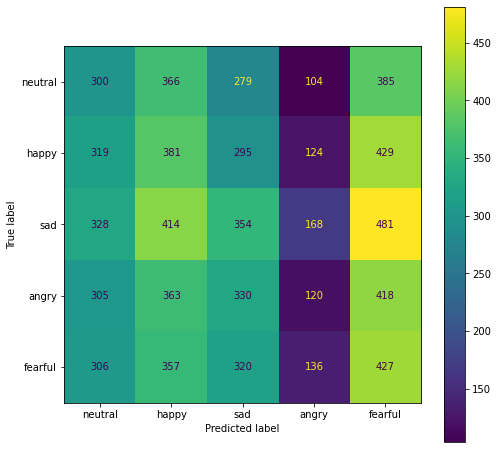

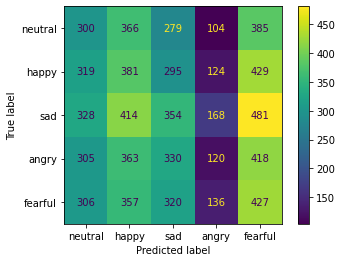

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
labels = ['neutral','happy','sad','angry','fearful']
## Display the visualization of the Confusion Matrix.
y_pred = model.predict(X_test).argmax(axis=1)
# print(y_pred.argmax(axis=1))
fig, ax = plt.subplots(figsize=(8,8))
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
ax = ConfusionMatrixDisplay.from_predictions( y_test,y_pred, display_labels=labels).plot(ax=ax)


In [ ]:
from tensorflow import keras
old = keras.models.load_model('cnn_63.h5')
old.summary()

In [ ]:
from IPython.display import Image 
from keras.utils import vis_utils

vis_utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

# Image('model.png')


